In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest, GradientBoostingRegressor, RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, Lasso
from sklearn.feature_selection import SelectKBest, f_regression
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import kurtosis, skew, boxcox
from regressors import stats
from numpy import mean
from numpy import std
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
train = pd.read_csv('train_filled_na_ord.csv')
test = pd.read_csv('test_filled_na_ord.csv')

In [3]:
train.drop('Id', axis = 1, inplace=True)
test.drop('Id', axis = 1, inplace=True)

# Outlier Detection

In [4]:
data_mean, data_std = mean(train), std(train)

In [5]:
cut_off = data_std * 3
lower, upper = data_mean - cut_off, data_mean + cut_off

outliers = {}
for col in ['LotFrontage','LotArea','MasVnrArea','YearBuilt','YearRemodAdd','BsmtFinSF1','BsmtFinSF2',
            'BsmtUnfSF','TotalBsmtSF','1stFlrSF','2ndFlrSF','GrLivArea','GarageArea','WoodDeckSF',
           'OpenPorchSF','EnclosedPorch']:
    m = train[col].between(lower[col], upper[col], inclusive=True)
    outliers[col] = train[~m]
    
    

In [6]:
outlier_indices = set()
for col in outliers:
    print(col, len(outliers[col]))
    for idx in list(outliers[col].index):
        #print(idx)
        outlier_indices.add(idx)
        

LotFrontage 15
LotArea 13
MasVnrArea 32
YearBuilt 6
YearRemodAdd 0
BsmtFinSF1 6
BsmtFinSF2 50
BsmtUnfSF 11
TotalBsmtSF 10
1stFlrSF 12
2ndFlrSF 4
GrLivArea 16
GarageArea 7
WoodDeckSF 22
OpenPorchSF 27
EnclosedPorch 51


In [7]:
train = train.drop(outlier_indices, axis=0)

# Dropping Columns with all Zeroes

In [8]:
allZeroCols = train.columns[(train == 0).all()].to_list()
train = train.drop(allZeroCols, axis=1)
test = test.drop(allZeroCols, axis=1)

# Model Testing

In [9]:
def getFeatureImportance(num, cols, features_importances_, sort):
    
    feature_importances = zip(cols, features_importances_)
    sorted_importance = sorted(list(feature_importances),key= lambda x: abs(x[1]),reverse=False if sort == 'ascending' else True)

    f, ax = plt.subplots(figsize=(13, 9))
    sns.barplot([x[0] for x in sorted_importance[:num]], [x[1] for x in sorted_importance[:num]])
    plt.xticks(rotation=90)
    
    return sorted_importance

In [10]:
X = train.loc[:, train.columns != 'SalePrice']
y = train['SalePrice']

## Random Forest

In [11]:
model = RandomForestRegressor()
params = {'n_estimators':[1000], 'max_features':['sqrt'], 'criterion':['mse']}
gridRf = GridSearchCV(model, param_grid=params, cv=5)
gridRf.fit(X, y)
print(gridRf.cv_results_)
print(gridRf.best_params_)
print(gridRf.best_score_)

{'mean_fit_time': array([2.22030873]), 'std_fit_time': array([0.10899302]), 'mean_score_time': array([0.09351072]), 'std_score_time': array([0.00370661]), 'param_criterion': masked_array(data=['mse'],
             mask=[False],
       fill_value='?',
            dtype=object), 'param_max_features': masked_array(data=['sqrt'],
             mask=[False],
       fill_value='?',
            dtype=object), 'param_n_estimators': masked_array(data=[1000],
             mask=[False],
       fill_value='?',
            dtype=object), 'params': [{'criterion': 'mse', 'max_features': 'sqrt', 'n_estimators': 1000}], 'split0_test_score': array([0.90340218]), 'split1_test_score': array([0.91484958]), 'split2_test_score': array([0.86776774]), 'split3_test_score': array([0.90116276]), 'split4_test_score': array([0.86935256]), 'mean_test_score': array([0.89130697]), 'std_test_score': array([0.01915086]), 'rank_test_score': array([1], dtype=int32)}
{'criterion': 'mse', 'max_features': 'sqrt', 'n_estimator

/Users/baileyrusso/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[('TotalSF', 0.11518746926732056),
 ('TotalIndoorSF', 0.09622743829914908),
 ('OverallQual', 0.09118030879230993),
 ('GrLivAreaHighQualitySF', 0.051438757367953704),
 ('YearBuilt', 0.04768743237076497),
 ('ExterQual', 0.04566556890638774),
 ('GrLivArea', 0.04182710122537359),
 ('KitchenQual', 0.039453376535962696),
 ('BsmtQual', 0.03864569170969177),
 ('TotalBsmtSF', 0.030410438067079347),
 ('GarageArea', 0.030234983903604663),
 ('GarageYrBlt', 0.029591227024066264),
 ('GarageCars', 0.02775497358938121),
 ('1stFlrSF', 0.023367967370053054),
 ('Baths', 0.02295791365868005),
 ('YearRemodAdd', 0.019817608932823364),
 ('BsmtFinSF1', 0.018072043092256705),
 ('FullBath', 0.017477637967959123),
 ('LotArea', 0.01179546414000762),
 ('GarageType', 0.01155473387379341),
 ('2ndFlrSF', 0.009732059641935626),
 ('TotRmsAbvGrd', 0.009426848381009843),
 ('OpenPorchSF', 0.009093522149586353),
 ('FireplaceQu', 0.008908777814671646),
 ('LotFrontage', 0.008794394378979874),
 ('Fireplaces', 0.00867738347996

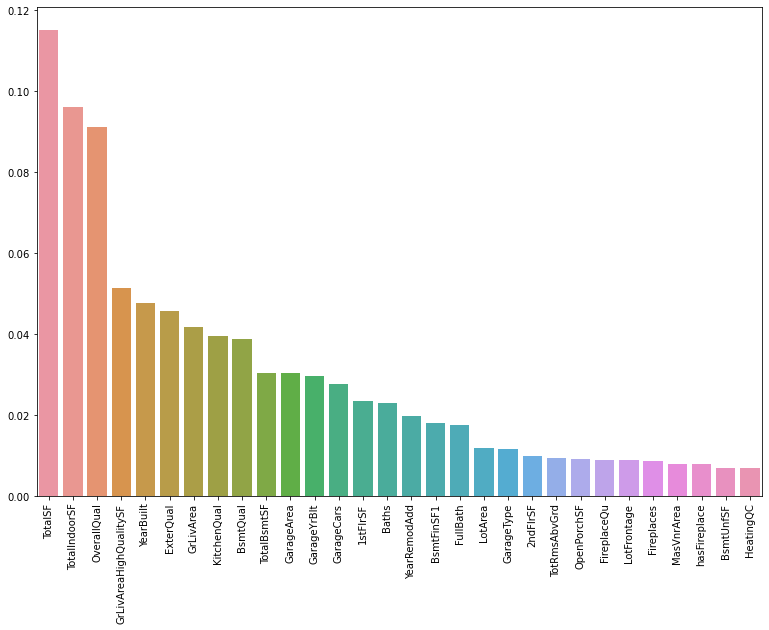

In [12]:
getFeatureImportance(30, X.columns, gridRf.best_estimator_.feature_importances_, sort='descending')

In [13]:
gridRf.score(X, y)

0.9858971210034134

## Gradient Boosting Regressor

In [14]:
model = GradientBoostingRegressor()
params = {'n_estimators': [500,600,700],
          'max_depth':[1,2,3,4,5],
          'max_features':['sqrt'],
          'subsample':[1,0.9,0.8,0.7], 
          'loss':['ls']}

gridGbr = GridSearchCV(model, param_grid=params, cv=5)
gridGbr.fit(X, y)
print(gridGbr.cv_results_)
print(gridGbr.best_params_)
print(gridGbr.best_score_)

{'mean_fit_time': array([0.18177304, 0.22814746, 0.21286464, 0.21128788, 0.20502481,
       0.2852354 , 0.30418949, 0.32201791, 0.26058245, 0.34249377,
       0.31765699, 0.30265422, 0.28228073, 0.28251781, 0.26946931,
       0.2612669 , 0.29057226, 0.33128471, 0.31804657, 0.31888285,
       0.34030719, 0.37499242, 0.39637284, 0.38206549, 0.34806299,
       0.42549663, 0.37072406, 0.31838374, 0.46522584, 0.43831925,
       0.4343708 , 0.453474  , 0.47050734, 0.48318043, 0.49940519,
       0.4382103 , 0.41428456, 0.43017507, 0.42742   , 0.38901482,
       0.46667137, 0.48808079, 0.46710505, 0.44514599, 0.53269558,
       0.54280596, 0.52597971, 0.49709702, 0.44599319, 0.45830822,
       0.46468973, 0.43055263, 0.55228682, 0.56473804, 0.54400544,
       0.51115403, 0.64602971, 0.66847839, 0.61886644, 0.57107058]), 'std_fit_time': array([0.00874881, 0.01588329, 0.01290629, 0.00712672, 0.00559318,
       0.03351306, 0.0381619 , 0.02846909, 0.01613485, 0.02956629,
       0.01222107, 0.00501

/Users/baileyrusso/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[('TotalIndoorSF', 0.1369645913024918),
 ('OverallQual', 0.11038808081322228),
 ('GarageCars', 0.09056137403369266),
 ('YearRemodAdd', 0.06801773165043663),
 ('KitchenQual', 0.06661139614976384),
 ('TotalSF', 0.05264450792834563),
 ('GrLivArea', 0.05136485115566487),
 ('BsmtQual', 0.03921513015930241),
 ('GarageArea', 0.03574131957233686),
 ('GrLivAreaHighQualitySF', 0.032815545228452606),
 ('BsmtFinSF1', 0.032257328024168606),
 ('YearBuilt', 0.0294599912247387),
 ('GarageYrBlt', 0.02514808269216717),
 ('1stFlrSF', 0.020476296073769537),
 ('TotalBsmtSF', 0.019438052675571284),
 ('FullBath', 0.015598507686733412),
 ('OpenPorchSF', 0.013984099208317178),
 ('MasVnrArea', 0.012543335049439783),
 ('2ndFlrSF', 0.011599104370241167),
 ('Fireplaces', 0.009969430489572283),
 ('LotArea', 0.009120114389881239),
 ('ExterQual', 0.00825804841246811),
 ('GarageType', 0.008214377862652963),
 ('GarageFinish', 0.007825436834258523),
 ('Baths', 0.007238837062896829),
 ('OverallCond', 0.007120689245930641

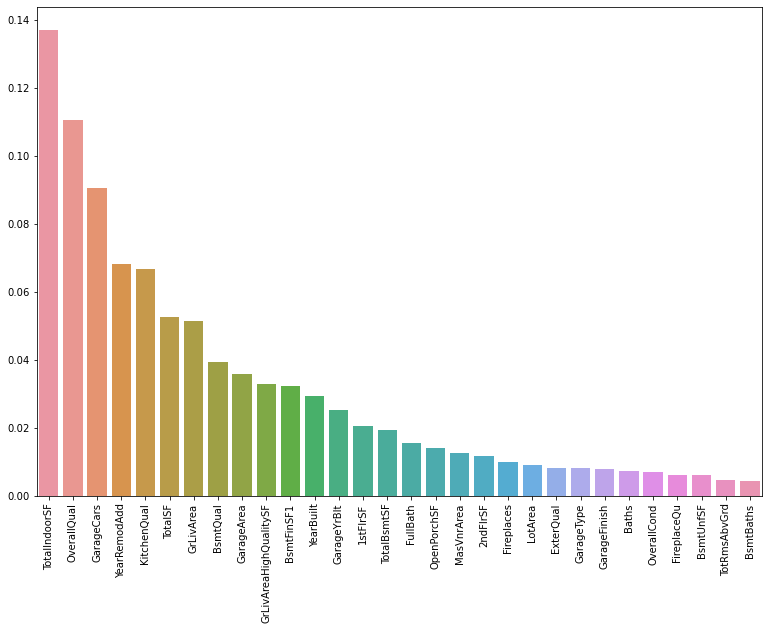

In [15]:
getFeatureImportance(30, X.columns, gridGbr.best_estimator_.feature_importances_, sort='descending')

In [16]:
gridGbr.score(X, y)

0.9930314379856661

# Test Predictions

In [35]:
gridGbr_predictions = gridGbr.predict(test)
gridGbr_predictions = pd.DataFrame(gridGbr_predictions)
gridGbr_predictions.index = gridGbr_predictions.index + 1461
gridGbr_predictions = gridGbr_predictions.rename(columns={0:'SalePrice'})
gridGbr_predictions = gridGbr_predictions.rename_axis('Id')


SalePrice
Id                 
1461  127027.823437
1462  163735.894342
1463  196839.961248
1464  193430.624115
1465  189740.044087
...             ...
2915   77901.579872
2916   81571.017418
2917  166285.147514
2918  119022.808627
2919  231411.940761

[1459 rows x 1 columns]

In [36]:
#gridGbr_predictions.to_csv('submission12.csv')